# G2 XPCS workflow for beamline 7011 @ ALS running on NERSC

If running on NERSC please make sure you are using a `pytorch` kernel


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch as t
from BL7011 import AndorDataLoader, AndorDataVisualizer # this is where we can call specific things from the beam line, this can be constantly updated
import h5py

# check if gpu is available:
print("CUDA available:", t.cuda.is_available())
filepath = "data/example_data/"

CUDA available: False


In [2]:
# filename = "xpcs_370K_813943d7-b3f7-40f0-8eb1-3711fb861e31.h5"
filename = "370K_81"

In [3]:
# Load data
andor = AndorDataLoader(filepath, filename)

# Set ROIs
andor.set_rois({
    "red": [[790, 800], [90,100]],
    "yellow": [[500, 550], [250,350]],
    #"blue": [[600, 800], [300,450]],
})
# Create visualizer and plot
visualizer = AndorDataVisualizer(andor)


Found file: data/example_data/xpcs_370K_813943d7-b3f7-40f0-8eb1-3711fb861e31.h5


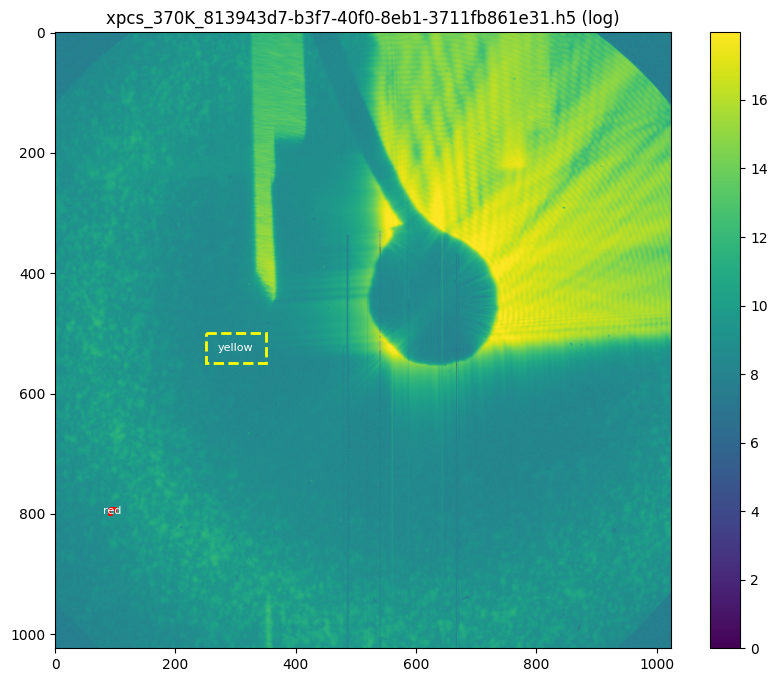

In [4]:
visualizer.plot_sum_frames()

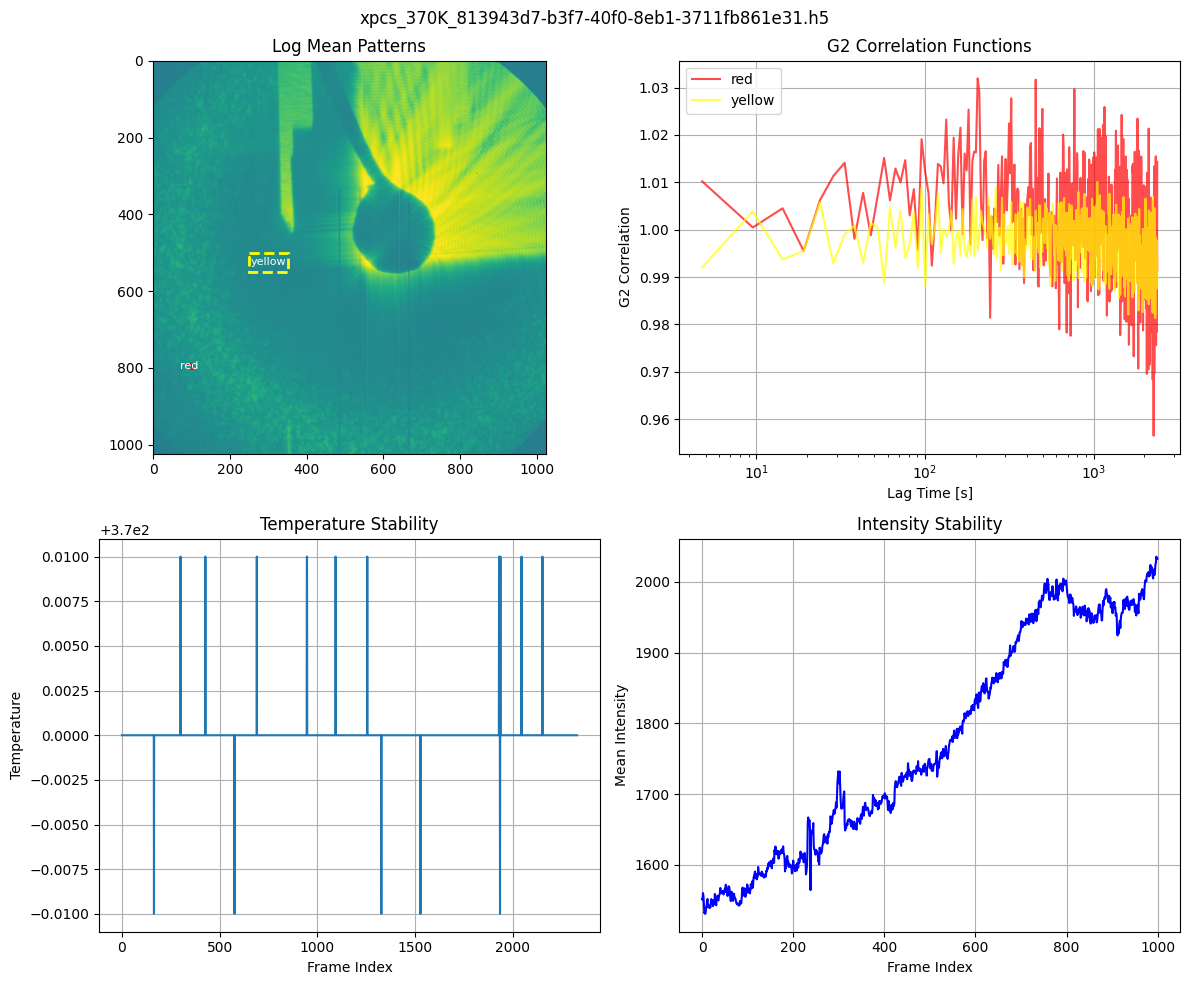

In [5]:
# Or for the complete overview:
visualizer.plot_complete_overview()

In [7]:
red = andor.compute_twotime_for_roi("red")

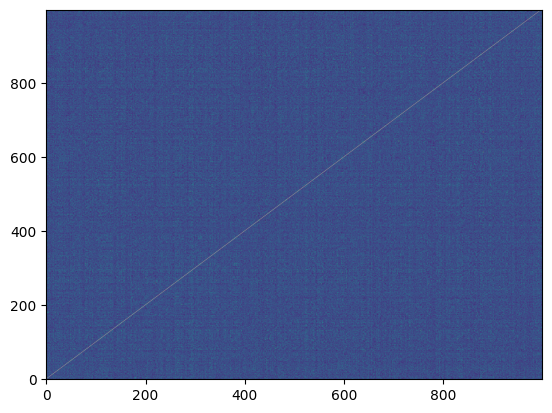

In [8]:
plt.imshow(red.cpu().numpy(), cmap='viridis', aspect='auto', origin='lower')